In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression


from sklearn.feature_selection import RFE


In [2]:
data = pd.read_excel('./data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


___

### Baseline без обработки

In [4]:
# Инициализируем функцию для отслеживания метрик
def print_metrics(y_train, y_train_predict, y_test, y_test_predict, name=''):
    print(f'Train R^2 {name}: {round(metrics.r2_score(y_train, y_train_predict),3)}')
    print(f'Train MAE {name}: {round(metrics.mean_absolute_error(y_train, y_train_predict),3)}')
    print(f'Train MAPE {name}: {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100,2)}')
    
    print('\n')
    
    print(f'Test R^2 {name}: {round(metrics.r2_score(y_test, y_test_predict),3)}')
    print(f'Test MAE {name}: {round(metrics.mean_absolute_error(y_test, y_test_predict),3)}')
    print(f'Test MAPE {name}: {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100,2)}')

In [5]:
# Без обработки уберем категориальные строковые фиты, скинем пропуски и оставим дубликаты
base_columns = [i for i in data.dtypes.index if data.dtypes.loc[i] != 'object']
base_data = data[base_columns]

base_data = base_data.dropna()
base_data = base_data.drop_duplicates()

X_base = base_data.drop(['price'], axis=1)
y_base = base_data['price']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_lr = linear_model.LinearRegression()
base_lr.fit(X_train_b, y_train_b)

y_train_b_pred = base_lr.predict(X_train_b)
y_test_b_pred = base_lr.predict(X_test_b)

print_metrics(y_train_b, y_train_b_pred, y_test_b, y_test_b_pred) 

Train R^2 : 0.513
Train MAE : 4876.315
Train MAPE : 8291.01


Test R^2 : 0.661
Test MAE : 4480.368
Test MAPE : 3616.38


---

### RFE для baseline

In [6]:
estimator = linear_model.LinearRegression()
selectorerf = RFE(estimator, n_features_to_select=3, step=1)
selectorerf = selectorerf.fit(X_train_b, y_train_b)

rfe_selector = selectorerf.get_feature_names_out().tolist()
print(f'MVP features RFE: {rfe_selector}') 

MVP features RFE: ['year', 'condition', 'cylinders']


> Наибольший вес при выборе метода RFE составили фиты: year, condition, cylinders

In [7]:
lr_rfe = linear_model.LinearRegression()
lr_rfe.fit(X_train_b[rfe_selector], y_train_b)
y_train_pred_rfe = lr_rfe.predict(X_train_b[rfe_selector])
y_test_pred_rfe = lr_rfe.predict(X_test_b[rfe_selector])

print_metrics(y_train_b, y_train_pred_rfe, y_test_b, y_test_pred_rfe)


Train R^2 : 0.489
Train MAE : 5173.458
Train MAPE : 8421.76


Test R^2 : 0.642
Test MAE : 4739.32
Test MAPE : 3878.66


---

#### KBest для baseline

In [8]:
selectorkb = SelectKBest(f_regression, k=3)
selectorkb.fit(X_train_b, y_train_b)

kbest_selector = selectorkb.get_feature_names_out().tolist()
print(f'MVP features KBest: {kbest_selector}')

MVP features KBest: ['year', 'condition', 'odometer']


> Наибольший вес при выборе метода Kbest составили фиты: year, condition, odometer

In [9]:
lr_kbest = linear_model.LinearRegression()
lr_kbest.fit(X_train_b[kbest_selector], y_train_b)
y_train_pred_kbest = lr_kbest.predict(X_train_b[kbest_selector])
y_test_pred_kbest = lr_kbest.predict(X_test_b[kbest_selector])

print_metrics(y_train_b, y_train_pred_kbest, y_test_b, y_test_pred_kbest) 

Train R^2 : 0.502
Train MAE : 5003.878
Train MAPE : 8796.73


Test R^2 : 0.652
Test MAE : 4627.646
Test MAPE : 3634.62


### Вывод (все нижеследующее касается тестовой выборки, хотя и тренировочная обладает теми же характеристиками):
### При проведенном исследовании я выявил следующее:
#### 1) Методы RFE и Kbest отдают больший вес разным фитам.
#### 2) По метрике R^2 выигрывает Kbest, так же показатель MAPE и MAE выглядят лучше, но все равно вне разумных пределов.
#### 3) Различия метрик KBest от baseline статистически не значимы.
#### Ниже я попробовал провести более детальный анализ.

---

## Дальнейший блок я сделал потому как не был уверен в том, что этого делать не нужно, ибо хоть в постановке задачи этого и не было, тем не менее дальнейшие шаги предполагаются при моделировании (хотя возможно что-то я упустил), так же не было уверености, что поведение метрик не изменится после поверхностного EDA. 
## Имеется ввиду, что ответ на на вопрос что лучше: RFE, SelectKBest или модель на всех признаках может отличаться для baseline-модели и моделей на предобработанных данных.

---

### Предобработка данных. Я посчитал разумным провести полный цикл обработки данных для получения наиболее чистых значений метрик для задания практики

#### Дубликаты

In [10]:
data = data.drop_duplicates()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4734 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         4734 non-null   int64  
 1   year          4734 non-null   int64  
 2   condition     4734 non-null   int64  
 3   cylinders     4734 non-null   int64  
 4   odometer      4734 non-null   int64  
 5   title_status  4734 non-null   object 
 6   transmission  4734 non-null   object 
 7   drive         4466 non-null   object 
 8   size          3592 non-null   object 
 9   lat           4734 non-null   float64
 10  long          4734 non-null   float64
 11  weather       4612 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 480.8+ KB


---

#### Пропуски

In [12]:
# Процент пропусков по фитам
data.isnull().mean()*100

price            0.000000
year             0.000000
condition        0.000000
cylinders        0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
drive            5.661174
size            24.123363
lat              0.000000
long             0.000000
weather          2.577102
dtype: float64

### Заполним пропуски модельным подходом

In [13]:
# Заполним все пропуски через предсказания модели
X = data.drop('price', axis=1)
y = data['price']

# Создадим список фитов с пропусками
# получим список строковых обозначений фитов
list_of_empty = [i for i in X.isnull().sum().index if X[i].isnull().sum() > 0]

# Создадим копии первичного фрейма для заполнения пропусков
weather = X.copy()  # числовой признак будем использовать линейную регрессию
size = X.copy()  # категориальный будем использовать логистическую
drive = X.copy()  # категориальный

# Создадим блок фреймов наполненных пропусками по целевым колонкам
test_weather_data = weather[weather['weather'].isna()]
test_size_data = size[size['size'].isna()]
test_drive_data = drive[drive['drive'].isna()]

# Удалим все пропуски
weather.dropna(inplace=True)
size.dropna(inplace=True)
drive.dropna(inplace=True)

# Для каждого фита создадим трейн/тест, скинув на трейне фиты с пустотами
y_train_weather = weather['weather']
# здесь скидываем и пустые фиты и целевой фит
X_train_weather = weather.drop(list_of_empty, axis=1)
X_test_weather = test_weather_data.drop(list_of_empty, axis=1)

y_train_size = size['size']
X_train_size = size.drop(list_of_empty, axis=1)
X_test_size = test_size_data.drop(list_of_empty, axis=1)

y_train_drive = drive['drive']
X_train_drive = drive.drop(list_of_empty, axis=1)
X_test_drive = test_drive_data.drop(list_of_empty, axis=1)

# Приступим к кодированию категориальных признаков через one hot для увеличения предсказательной способностей модели
one_hot_encoder_weather = OneHotEncoder()  # создаем объект кодировщика
one_hot_encoder_size = OneHotEncoder()
one_hot_encoder_drive = OneHotEncoder()

# создаем список фитов для кодировки
categorial_cols = ['cylinders', 'title_status', 'transmission']

# Закодируем блок
X_train_weather_oh = one_hot_encoder_weather.fit_transform(
    X_train_weather[categorial_cols]).toarray()
X_test_weather_oh = one_hot_encoder_weather.transform(
    X_test_weather[categorial_cols]).toarray()

X_train_size_oh = one_hot_encoder_size.fit_transform(
    X_train_size[categorial_cols]).toarray()
X_test_size_oh = one_hot_encoder_size.transform(
    X_test_size[categorial_cols]).toarray()

X_train_drive_oh = one_hot_encoder_drive.fit_transform(
    X_train_drive[categorial_cols]).toarray()
X_test_drive_oh = one_hot_encoder_drive.transform(
    X_test_drive[categorial_cols]).toarray()

# Создадим из полученных закодированных фитов датафреймы
# т.к. у нас закодированы одни и те же категориальные фиты мы можем получить имена колонок из любого кодировщика
columns = one_hot_encoder_weather.get_feature_names_out()

X_train_weather_oh_df = pd.DataFrame(data=X_train_weather_oh, columns=columns)
X_test_weather_oh_df = pd.DataFrame(data=X_test_weather_oh, columns=columns)

X_train_size_oh_df = pd.DataFrame(data=X_train_size_oh, columns=columns)
X_test_size_oh_df = pd.DataFrame(data=X_test_size_oh, columns=columns)

X_train_drive_oh_df = pd.DataFrame(data=X_train_drive_oh, columns=columns)
X_test_drive_oh_df = pd.DataFrame(data=X_test_drive_oh, columns=columns)

# Сбросим индексы у извлеченных выборок т.к они пришли из основного датафрейма
y_train_weather = y_train_weather.reset_index().drop(['index'], axis=1)
X_train_weather = X_train_weather.reset_index().drop(['index'], axis=1)
X_test_weather = X_test_weather.reset_index().drop(['index'], axis=1)

y_train_size = y_train_size.reset_index().drop(['index'], axis=1)
X_train_size = X_train_size.reset_index().drop(['index'], axis=1)
X_test_size = X_test_size.reset_index().drop(['index'], axis=1)

y_train_drive = y_train_drive.reset_index().drop(['index'], axis=1)
X_train_drive = X_train_drive.reset_index().drop(['index'], axis=1)
X_test_drive = X_test_drive.reset_index().drop(['index'], axis=1)

# Объединим фреймы
X_train_weather_new = pd.concat(
    [X_train_weather, X_train_weather_oh_df], axis=1)
X_test_weather_new = pd.concat([X_test_weather, X_test_weather_oh_df], axis=1)

X_train_size_new = pd.concat([X_train_size, X_train_size_oh_df], axis=1)
X_test_size_new = pd.concat([X_test_size, X_test_size_oh_df], axis=1)

X_train_drive_new = pd.concat([X_train_drive, X_train_drive_oh_df], axis=1)
X_test_drive_new = pd.concat([X_test_drive, X_test_drive_oh_df], axis=1)

# Удалим категориальные фиты, т.к. мы их уже закодировали
X_train_weather_new = X_train_weather_new.drop(columns=categorial_cols, axis=1)
X_test_weather_new = X_test_weather_new.drop(columns=categorial_cols, axis=1)

X_train_size_new = X_train_size_new.drop(columns=categorial_cols, axis=1)
X_test_size_new = X_test_size_new.drop(columns=categorial_cols, axis=1)

X_train_drive_new = X_train_drive_new.drop(columns=categorial_cols, axis=1)
X_test_drive_new = X_test_drive_new.drop(columns=categorial_cols, axis=1)

# Произведем моделирование linear regression для числовых, logistic regression для категориальных
weather_model = linear_model.LinearRegression()
weather_model.fit(X_train_weather_new, y_train_weather)
y_test_weather = weather_model.predict(X_test_weather_new)

size_model = linear_model.LogisticRegression(
    class_weight='balanced', random_state=42, max_iter=500, n_jobs=-1)
size_model.fit(X_train_size_new, y_train_size['size'].ravel())
y_test_size = size_model.predict(X_test_size_new)

drive_model = linear_model.LogisticRegression(
    class_weight='balanced', random_state=42, max_iter=500, n_jobs=-1)
drive_model.fit(X_train_drive_new, y_train_drive['drive'].ravel())
y_test_drive = drive_model.predict(X_test_drive_new)

# Запихнем результаты заполнений в датафрейм
X.loc[X['weather'].isna(), 'weather'] = y_test_weather
X.loc[X['size'].isna(), 'size'] = y_test_size
X.loc[X['drive'].isna(), 'drive'] = y_test_drive

In [14]:
new_data = pd.concat([X,y], axis=1)

In [15]:
new_data.isnull().mean()*100

year            0.0
condition       0.0
cylinders       0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
size            0.0
lat             0.0
long            0.0
weather         0.0
price           0.0
dtype: float64

---

#### Выбросы

In [16]:
graph_data = [i for i in new_data.dtypes.index if new_data.dtypes.loc[i] != 'object']

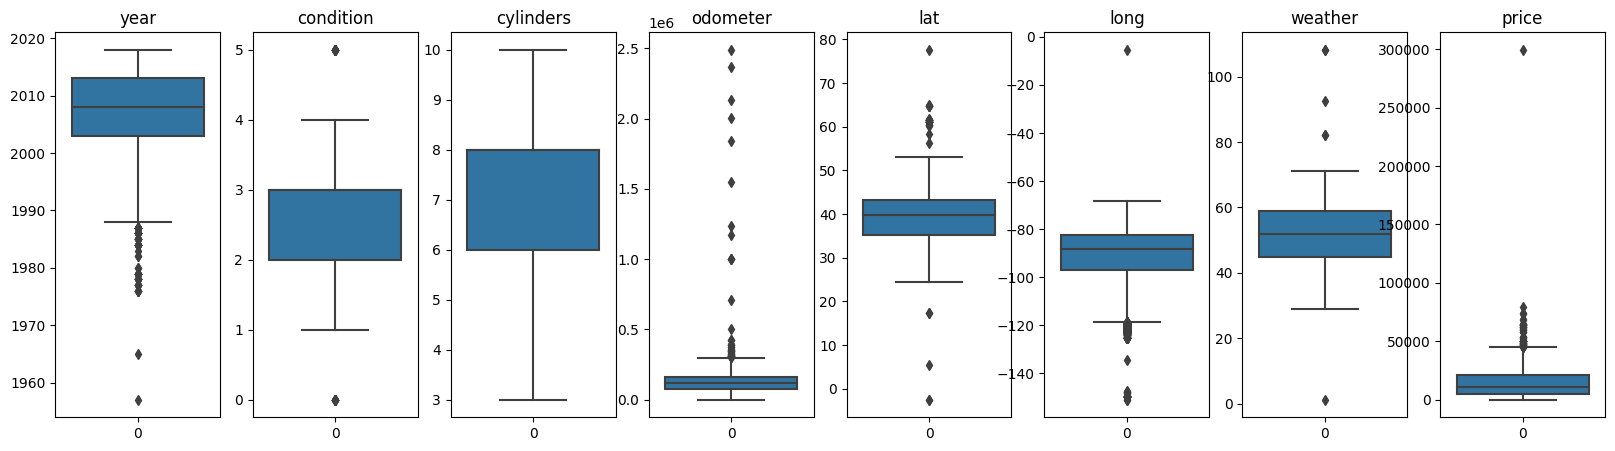

In [17]:
fig, axes = plt.subplots(1, len(graph_data), figsize=(20,5))

for number, feat in enumerate(graph_data):
    graph = sns.boxplot(data=new_data[feat], ax=axes[number])
    graph.set_title(f'{feat}')

### Посмотрим на распределение признаков для дальнейшей работы с признаками

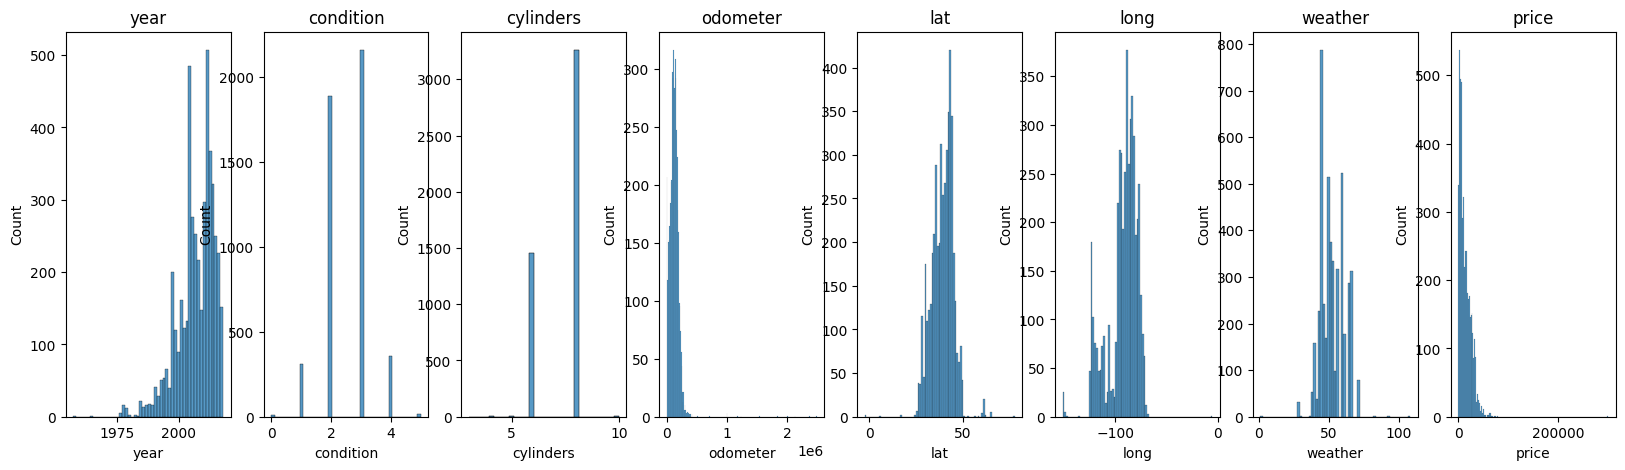

In [18]:
fig, axes = plt.subplots(1, len(graph_data), figsize=(20,5))

for number, feat in enumerate(graph_data):
    graph = sns.histplot(data=new_data[feat], ax=axes[number])
    graph.set_title(f'{feat}')

In [19]:
def outliers_z_score(data, feature, left_mod=3, right_mod=3, log_scale=False):
    """Function for finding outliers by z-method with adjustment option for left and right multiplier.

    Args:
        data (DataFrame): DataFrame which will be used to find outliers.
        feature (string): Name of a column in DF which will be inspected for outliers.
        left_mod (int, optional): lower boundary multiplier. Defaults to 3.
        right_mod (int, optional): upper boundary multiplier. Defaults to 3.
        log_scale (bool, optional): converting data in logarithmic representation in case of lognormal destribution of
        original data. Defaults to False.

    Returns:
        DataFrame: returns two copies of the original DataFrame contain DF's with outliers and cleaned data.
    """    ''''''

    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]

    mu = x.mean()

    sigma = x.std()

    lower_bound = mu - left_mod * sigma

    upper_bound = mu + right_mod * sigma

    outliers = data[(x < lower_bound) | (x > upper_bound)]

    cleaned = data[(x > lower_bound) & (x < upper_bound)]

    print(f'Number of outliers by z-method: {outliers.shape[0]}')
    print(f'Resulting number of lines cleared of outliers: {cleaned.shape[0]}')

    return outliers, cleaned

In [20]:
# Удалим выбросы в наиболее подходящих для этого фитах
_, new_data = outliers_z_score(new_data, 'price', left_mod=1.5, right_mod=1.5, log_scale=True)
_, new_data = outliers_z_score(new_data, 'year')
_, new_data = outliers_z_score(new_data, 'odometer', left_mod=2.0, right_mod=2.0, log_scale=True)

Number of outliers by z-method: 236
Resulting number of lines cleared of outliers: 4498
Number of outliers by z-method: 59
Resulting number of lines cleared of outliers: 4439
Number of outliers by z-method: 136
Resulting number of lines cleared of outliers: 4303


---

### Закодируем признаки для моделирования

In [21]:
# Кодирование признаков датасета
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']

for column in columns_to_change:
    print('Число уникальных значений признака {}: '.format(
        column), new_data[column].nunique())


Число уникальных значений признака cylinders:  6
Число уникальных значений признака title_status:  5
Число уникальных значений признака transmission:  3
Число уникальных значений признака drive:  3
Число уникальных значений признака size:  4


In [22]:
# Закодируем строковые фиты порядковым кодированием
encoder = OrdinalEncoder()
data_ordinal = encoder.fit_transform(new_data[columns_to_change])

# запишем полученные названия новых колонок в отдельную переменную
column_names = encoder.get_feature_names_out(columns_to_change)


In [23]:
# Создадим таблицу кодировок
data_ordinal = pd.DataFrame(data=data_ordinal, columns=column_names, index=new_data.index)

In [24]:
# Объединим полученые датафреймы
encoded_data = new_data.drop(columns_to_change, axis=1)
encoded_data = pd.concat([encoded_data, data_ordinal], axis=1)

In [25]:
X = encoded_data.drop(['price'], axis=1)
y = encoded_data['price']

In [26]:
col_names = ['odometer', 'weather']
X_scaled = X.copy()
x = X[col_names]

scaler = StandardScaler()

X_scaled[col_names] = scaler.fit_transform(x.values)
X_scaled.head()

,year,condition,odometer,lat,long,weather,cylinders,title_status,transmission,drive,size
0,2016,4,-1.166451,36.471500,-82.483400,0.770262,3.0,0.0,0.0,0.0,1.0
1,2009,2,-0.384821,40.468826,-74.281734,-0.069157,4.0,0.0,0.0,0.0,1.0
2,2002,2,1.098461,42.477134,-82.949564,-0.908576,4.0,0.0,0.0,0.0,1.0
4,2010,3,0.587098,49.210949,-123.114720,-1.412958,4.0,0.0,0.0,0.0,1.0
5,2003,3,0.609990,45.518031,-122.578752,-0.308991,4.0,0.0,0.0,0.0,1.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

___

### Моделирование с отобранными признаками по методу RFE

In [28]:
estimator = linear_model.LinearRegression()
selectorerf = RFE(estimator, n_features_to_select=3, step=1)
selectorerf = selectorerf.fit(X_train, y_train)

rfe_selector = selectorerf.get_feature_names_out().tolist()
print(f'MVP features RFE: {rfe_selector}') 

MVP features RFE: ['condition', 'odometer', 'transmission']


In [29]:
lr_rfe = linear_model.LinearRegression()
lr_rfe.fit(X_train[rfe_selector], y_train)
y_train_pred_rfe = lr_rfe.predict(X_train[rfe_selector])
y_test_pred_rfe = lr_rfe.predict(X_test[rfe_selector])

print_metrics(y_train, y_train_pred_rfe, y_test, y_test_pred_rfe)


Train R^2 : 0.486
Train MAE : 5697.723
Train MAPE : 77.3


Test R^2 : 0.45
Test MAE : 5670.4
Test MAPE : 74.19


### Моделирование с отобранными признаками по методу KBest

In [30]:
selectorkb = SelectKBest(f_regression, k=3)
selectorkb.fit(X_train, y_train)

kbest_selector = selectorkb.get_feature_names_out().tolist()
print(f'MVP features KBest: {kbest_selector}')

MVP features KBest: ['year', 'condition', 'odometer']


In [31]:
lr_kbest = linear_model.LinearRegression()
lr_kbest.fit(X_train[kbest_selector], y_train)
y_train_pred_kbest = lr_kbest.predict(X_train[kbest_selector])
y_test_pred_kbest = lr_kbest.predict(X_test[kbest_selector])

print_metrics(y_train, y_train_pred_kbest, y_test, y_test_pred_kbest) 

Train R^2 : 0.73
Train MAE : 4083.487
Train MAPE : 55.24


Test R^2 : 0.715
Test MAE : 4078.749
Test MAPE : 53.39


### Моделирование с полным набором признаков

In [32]:
full_lr = linear_model.LinearRegression()
full_lr.fit(X_train, y_train)

y_train_pred_full = full_lr.predict(X_train)
y_test_pred_full = full_lr.predict(X_test)

print_metrics(y_train, y_train_pred_full, y_test, y_test_pred_full) 

Train R^2 : 0.766
Train MAE : 3776.134
Train MAPE : 51.61


Test R^2 : 0.749
Test MAE : 3773.138
Test MAPE : 49.85


### Вывод о приоритетности подходов остался тем же что и для baseline модели